In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.architectures.sequential import Sequential
from src.models import TrainingArguments, LabeledData
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, activations, loss_functions, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'digits_classifier')

In [3]:
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 1e-4 # Learning rate for the optimizer
batch_size = 16 # Number of samples to use for each batch
epochs = 300 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the digits dataset
digits = load_digits()

# Extract the number of classes in the dataset
num_classes = len(np.unique(digits['target'])) # type: ignore

# Extract the input and output data
data = Tensor(data=digits.get("data", [])) # type: ignore
labels = Tensor(data=digits.get("target", []), dtype=np.int8) # type: ignore

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data((data, labels), train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data((X_train, y_train), train_valid_split, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (1151, 64) (1151,)
Validation set: (287, 64) (287,)
Testing set: (359, 64) (359,)


### Data Preprocessing

In [6]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [7]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = data_processing.one_hot_encoding(y=y_train, n_classes=num_classes)
y_valid_encoded = data_processing.one_hot_encoding(y=y_valid, n_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0].data)
print("One-hot encoded value:", y_train_encoded[0])

Sample target value: 3.0
One-hot encoded value: Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


### Data visualization

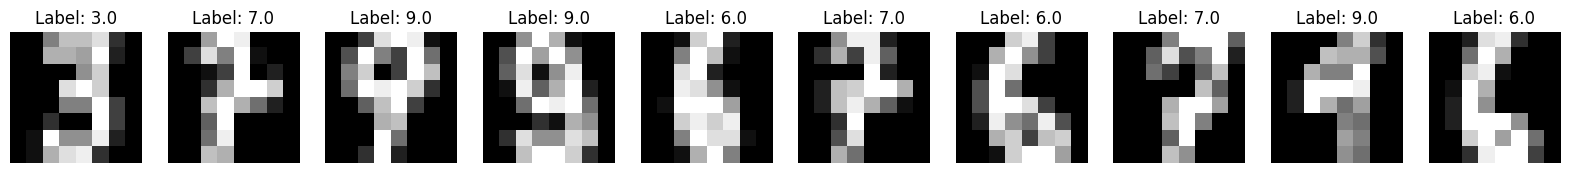

In [8]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
    
    reshaped_samples = []
    
    # Iterate over the samples
    for sample in samples:
        # Compute the new shape
        new_shape = np.sqrt(sample.shape).astype(int)[0]
        
        # Reshape the sample
        sample = sample.reshape(new_shape, new_shape)
        
        # Append the reshaped sample
        reshaped_samples.append(sample)
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(reshaped_samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
        
# Plot the first 10 samples
plot_samples(list(X_train.data[:10]), list(y_train.data[:10]))

### Building the model

In [9]:

model = Sequential(
    name = "Digits Classifier",
    modules = [
        layers.Dense(num_units=24, activation=activations.ReLU()),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        layers.Dense(num_units=32, activation=activations.ReLU()),
        layers.Dropout(rate=0.1),
        layers.Dense(num_units=12, activation=activations.Tanh()),
        layers.Dropout(rate=0.1),
        layers.Dense(num_units=num_classes, activation=activations.Softmax())
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy(from_logits=False)

### Initializing the model

In [10]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(X_train[:batch_size])

In [11]:
# Display the model summary
model.summary()
model.modules.summary()


Digits Classifier

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
digits_classifier.modules (ModuleList)                 (16, 10)            2934                
Total trainable parameters: 2934
-----------------------------------------------------------------------------------------------

digits_classifier.modules

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
module_list.0 (Dense)                                  (16, 24)            1560                
-----------------------------------------------------------------------------------------------
module_list.1 (BatchNormalization)                     (16, 24)            48                  
-------------------------------------------------------

### Training the model

In [12]:
# Create the training arguments
train_arguments = TrainingArguments(
    train_data = LabeledData(input={'x': X_train}, target=y_train_encoded),
    valid_data = LabeledData(input={'x': X_valid}, target=y_valid_encoded),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor="val_loss", patience=10)]
)

# Train the model
history = model.fit(train_arguments)

Epoch 1/300 --> loss: 2.3055 - accuracy: 0.12078 | val_loss: 2.2982 - val_accuracy: 0.16389                                                          
Epoch 2/300 --> loss: 2.2668 - accuracy: 0.1963 | val_loss: 2.2489 - val_accuracy: 0.25116                                                           
Epoch 3/300 --> loss: 2.226 - accuracy: 0.31366 | val_loss: 2.2036 - val_accuracy: 0.33843                                                           
Epoch 4/300 --> loss: 2.1898 - accuracy: 0.36748 | val_loss: 2.157 - val_accuracy: 0.48125                                                           
Epoch 5/300 --> loss: 2.1433 - accuracy: 0.4485 | val_loss: 2.0999 - val_accuracy: 0.52292                                                           
Epoch 6/300 --> loss: 2.0883 - accuracy: 0.50127 | val_loss: 2.0415 - val_accuracy: 0.57523                                                          
Epoch 7/300 --> loss: 2.0259 - accuracy: 0.54306 | val_loss: 1.9725 - val_accuracy: 0.59954         

In [13]:
# Save the model
model.save(model_path)

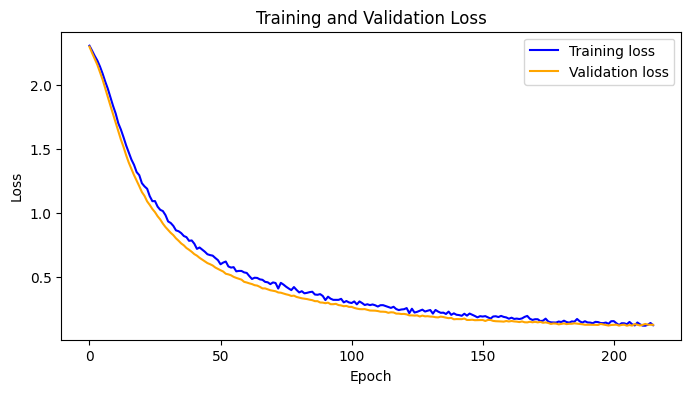

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Evaluation

In [15]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test)

# Apply the argmax function to the predictions
predictions = Tensor(np.argmax(predictions.data, axis=1), dtype=np.int8)

Accuracy: 0.96


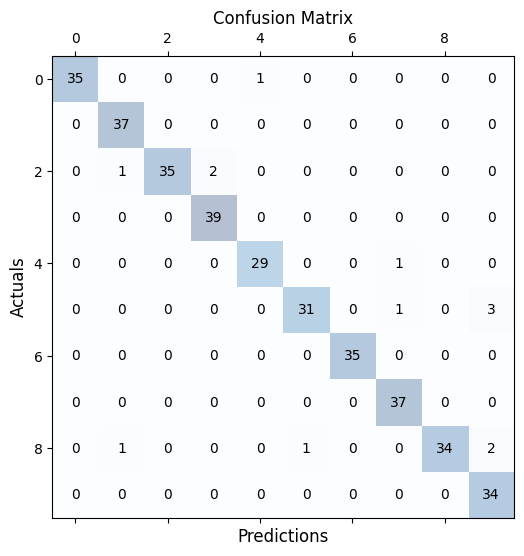

In [16]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test, predictions)
confusion_matrix = metrics.confusion_matrix(num_classes, y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

# Plot the confusion matrix
data_analysis.plot_confusion_matrix(confusion_matrix)